In [26]:
import os
import pandas as pd
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials

In [11]:
%%capture
%run credentials.ipynb

In [12]:
MY_SPOTIFY_ID = "11156353201"

In [13]:
def get_token(scope, user_id):
    return util.prompt_for_user_token(user_id, scope)

 <br>
 <h2>What have I been listening to recently</h2>
 <br>

In [14]:
token = get_token('user-top-read', MY_SPOTIFY_ID)
    
if token:
    sp = spotipy.Spotify(auth=token)
    sp.trace = False
    
    artists = sp.current_user_top_artists(time_range='short_term', limit=30)
    tracks = sp.current_user_top_tracks(time_range='short_term', limit=30)
        
else:
    print("not found")

In [15]:
df_artists = pd.DataFrame(artists['items'], columns=['name', 'genres', 'uri'])

In [16]:
from collections import ChainMap

df_tracks = pd.DataFrame(tracks['items'], columns=['artists', 'name'])
concatenated_df_tracks_artists = list(map(lambda x: dict(ChainMap(*x)), df_tracks['artists']))
tracks_artists_names = [x['name'] for x in concatenated_df_tracks_artists]
df_tracks_artists_names = pd.DataFrame(tracks_artists_names, columns={'artist': tracks_artists_names})
df_tracks_names = pd.DataFrame(tracks['items'], columns=['name'])

In [17]:
df_tracks = df_tracks.join(df_tracks_artists_names)
df_tracks.drop('artists', axis=1)

,name,artist
0,Voice in Headphones,Mount Eerie
1,Measurement Doesn’t Change The System At All,Eli Keszler
2,Exercises in Futility I,Mgła
3,Mechanical Bull,Stella Donnelly
4,AS Too Wrong,Amnesia Scanner
5,Leo,Holiday Sidewinder
6,Rattlesnake,King Gizzard & The Lizard Wizard
7,Audio Track 01,Delroy Edwards
8,"Circlesong 1, Early Chant",Tomasz Chyła Quintet
9,Love Time Feel,Hen Ogledd


<br>
<br>
<h2>What features of songs I prefer comparing to other users<h2>
<h6> the global data comes from <a href="https://www.kaggle.com/geomack/spotifyclassification/version/1" target="blank">kaggle</a></h6>

In [18]:
%matplotlib inline

import itertools as it
import numpy as np
import seaborn as sb

import time
import operator as op

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [ ]:
token = get_token('user-library-read', MY_SPOTIFY_ID)

if token:
    sp = spotipy.Spotify(auth=token)
    results = sp.current_user_saved_albums(limit=50)
else:
    print("not found")
    
items = results['items']

while results['next']:
    results = sp.next(results)
    items.extend(results['items'])
    
albums_id = list(map(lambda x: x.get('album', {}).get('id'), items))

tracks = []

for album_id in albums_id:
    try: 
        tracks.append(sp.album_tracks(album_id)['items'])
    except:
        time.sleep(5)
        tracks.append(sp.album_tracks(album_id)['items'])
        
        
tracks = list(it.chain.from_iterable(tracks))
tracks_ids = [track['id'] for track in tracks]

track_grouper = it.groupby(enumerate(tracks_ids), key=lambda pair: pair[0]//50)
track_chunks = [list(map(op.itemgetter(1), group)) for _, group in track_grouper]

features = list(it.chain.from_iterable(sp.audio_features(chunk) for chunk in track_chunks))

#pd.Dataframe(features)
#pd.to_csv('my_data.csv')

In [19]:
my_data = pd.read_csv('my_data.csv')
my_data = my_data.drop(['analysis_url', 'id', 'uri', 'type', 'track_href', 'time_signature', 'key', 'analysis_url', 'Unnamed: 0'], axis=1);

global_data = pd.read_csv('data.csv')
global_data = global_data.drop(columns=['time_signature', 'song_title', 'artist', 'target', 'key', 'Unnamed: 0'], axis=1);

In [20]:
maxs = my_data.max()

for column in my_data.columns:
    my_data[column] = my_data[column].div(maxs[column])
    
for column in global_data.columns:
    global_data[column] = global_data[column].div(maxs[column])

In [21]:
loudness_min = my_data['loudness'].min()
my_data['loudness'] = (my_data['loudness'] + abs(loudness_min)) * 0.1
global_data['loudness'] = (global_data['loudness'] + abs(loudness_min)) * 0.1

In [22]:
my_data_means = pd.DataFrame(my_data.mean(axis=0)).T
global_data_means = pd.DataFrame(global_data.mean(axis=0)).T

my_data_means['owner'] = 'me'
global_data_means['owner'] = 'kaggle users'

means = my_data_means.append(global_data_means)

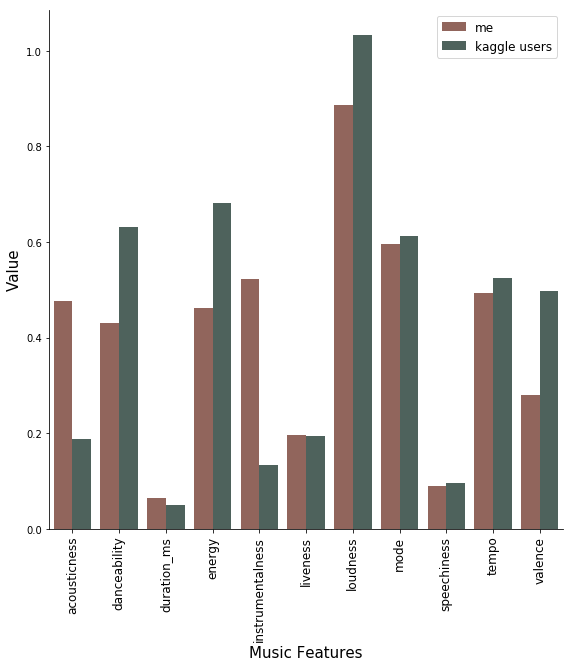

In [23]:
melted = means.melt('owner', var_name='columns', value_name='values')
sb.catplot(x='columns', y='values', hue='owner', data=melted, kind='bar', height=8, legend_out=False, palette=['#9a5f53', '#4b655d'])
plt.xticks(rotation=90, fontsize=12)
plt.xlabel('Music Features', fontsize=15)
plt.ylabel('Value', fontsize=15)
plt.legend(fontsize=12)
plt.show()

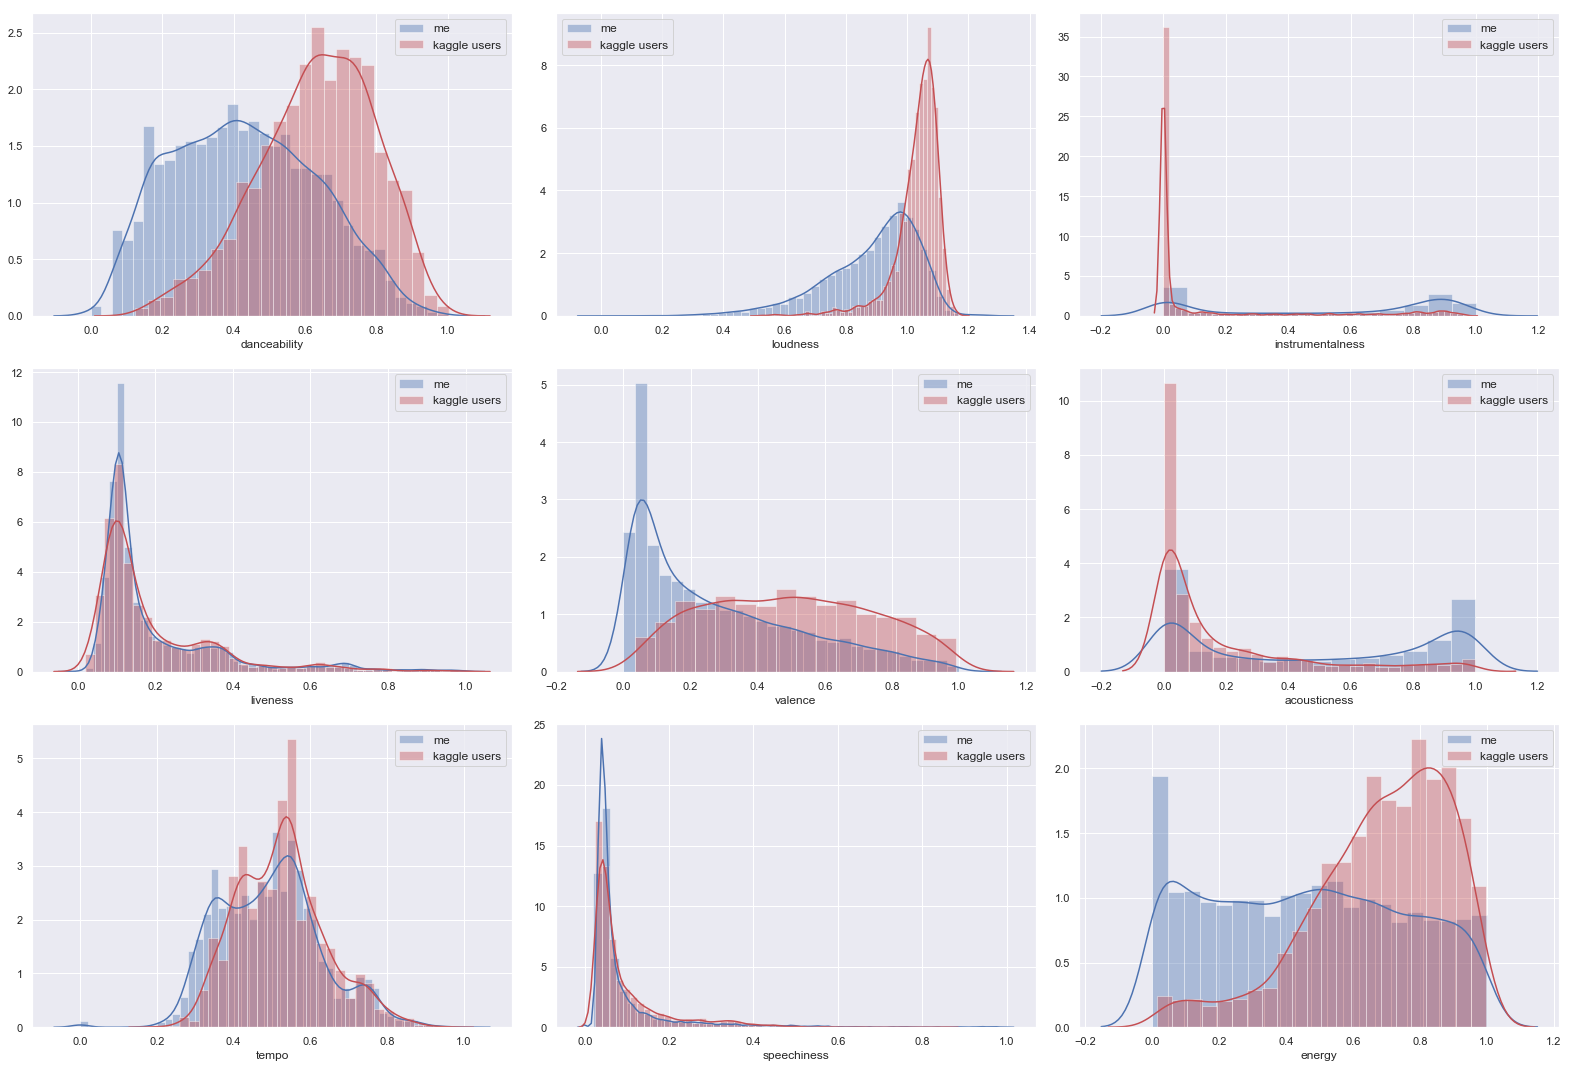

In [27]:
sb.set(rc={'figure.figsize':(22,15)})

plt.subplot(331)
sb.distplot(my_data['danceability'], label='me')
sb.distplot(global_data['danceability'], color='r', label='kaggle users')
plt.xlabel('danceability', fontsize=12)
plt.legend(fontsize=12)

plt.subplot(332)
sb.distplot(my_data['loudness'], label='me')
sb.distplot(global_data['loudness'], color='r', label='kaggle users')
plt.xlabel('loudness', fontsize=12)
plt.legend(fontsize=12)

plt.subplot(333)
sb.distplot(my_data['instrumentalness'], label='me')
sb.distplot(global_data['instrumentalness'], color='r', label='kaggle users')
plt.xlabel('instrumentalness', fontsize=12)
plt.legend(fontsize=12)

plt.subplot(334)
sb.distplot(my_data['liveness'], label='me')
sb.distplot(global_data['liveness'], color='r', label='kaggle users')
plt.xlabel('liveness', fontsize=12)
plt.legend(fontsize=12)

plt.subplot(335)
sb.distplot(my_data['valence'], label='me')
sb.distplot(global_data['valence'], color='r', label='kaggle users')
plt.xlabel('valence', fontsize=12)
plt.legend(fontsize=12)

plt.subplot(336)
sb.distplot(my_data['acousticness'], label='me')
sb.distplot(global_data['acousticness'], color='r', label='kaggle users')
plt.xlabel('acousticness', fontsize=12)
plt.legend(fontsize=12)

plt.subplot(337)
sb.distplot(my_data['tempo'], label='me')
sb.distplot(global_data['tempo'], color='r', label='kaggle users')
plt.xlabel('tempo', fontsize=12)
plt.legend(fontsize=12)

plt.subplot(338)
sb.distplot(my_data['speechiness'], label='me')
sb.distplot(global_data['speechiness'], color='r', label='kaggle users')
plt.xlabel('speechiness', fontsize=12)
plt.legend(fontsize=12)

plt.subplot(339)
sb.distplot(my_data['energy'], label='me')
sb.distplot(global_data['energy'], color='r', label='kaggle users')
plt.xlabel('energy', fontsize=12)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()